In [106]:
import nltk

In [305]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
%matplotlib inline

In [313]:
strDataDir = '/project/hackathon/hackers09/shared/data/'
strEchoCsv = os.path.join(strDataDir, 'df_echo.csv')
strRadCsv = os.path.join(strDataDir, 'df_radiology.csv')
strOutcomeCsv = os.path.join(strDataDir, 'df_outcome.csv')
strEncounterCsv = os.path.join(strDataDir, 'df_encounter.csv')

In [314]:
dfEcho = pd.read_csv(strEchoCsv, encoding='ISO-8859-1')
dfRad = pd.read_csv(strRadCsv, encoding='ISO-8859-1')
dfOutcome = pd.read_csv(strOutcomeCsv, encoding='ISO-8859-1')
dfEncounter = pd.read_csv(strEncounterCsv, encoding='ISO-8859-1')

In [293]:
def merge_outcome_echo(dfOutcome, dfEcho):
    """
    Merge outcome and echo dataframes after expanding each 
    to have single row per encounter.
    
    return: dfEchoAndOutcome, dfExpandedEcho, dfExpandedOutcome
    """
    
    ## Outcome expansion
    # Create columns for each unique outcome
    lsCols = []
    for strOutcome in dfOutcome['name_gen'].value_counts().index:
        lsCols += [strCol + '_' + strOutcome for strCol in dfOutcome.columns[2:]]
        
    lsUniqueCols = dfOutcome.columns[2:].tolist()

    dfExpandedOutcome = pd.DataFrame(columns=lsCols+['PATIENT_ID'])
    dfExpandedOutcome['HSP_ENC'] = dfOutcome['HSP_ENC'].value_counts().index
    dfExpandedOutcome = dfExpandedOutcome.set_index('HSP_ENC')

    for nEnc in dfOutcome['HSP_ENC'].value_counts().index:
        for nIdx in dfOutcome[dfOutcome['HSP_ENC']==nEnc].index:
            lsTempCols = [strCol + '_' + dfOutcome.at[nIdx, 'name_gen'] for strCol in lsUniqueCols]
            lsTempCols.append('PATIENT_ID')
            dfExpandedOutcome.loc[nEnc, lsTempCols] = dfOutcome.loc[nIdx, lsUniqueCols+['PATIENT_ID']].values
            
    # Create boolean column for order time < 48 hrs for any outcome
    lsOrderTimeCols = [strCol for strCol in dfExpandedOutcome.columns if 'ORDER_TIME' in strCol]
    
    dfExpandedOutcome['b48hr'] = np.zeros(dfExpandedOutcome.shape[0])
    for nEnc in dfExpandedOutcome.index:
        for nVal in dfExpandedOutcome.loc[nEnc, lsOrderTimeCols].values:
            if nVal < 172800:
                dfExpandedOutcome.at[nEnc, 'b48hr'] = 1
                
    # Column for minimum order time from all outcomes
    dfExpandedOutcome['MinOrderTime'] = dfExpandedOutcome.loc[:, lsOrderTimeCols].min(axis=1)
    dfExpandedOutcome = dfExpandedOutcome.sort_values('MinOrderTime')
    
    ## Echo expansion
    # Create columns for unique lines in echo narrative
    lsExpandedEchoCols = []
    for strNewLine in dfEcho['new_line'].value_counts().index.astype(str):
        lsExpandedEchoCols += [strCol + '_' + strNewLine for strCol in dfEcho.columns[3:]]
        
    lsUniqueEchoCols = dfEcho.columns[3:].tolist()

    dfExpandedEcho = pd.DataFrame(columns=['PATIENT_ID']+lsExpandedEchoCols)
    dfExpandedEcho['HSP_ENC'] = dfEcho['HSP_ENC'].value_counts().index
    dfExpandedEcho = dfExpandedEcho.set_index('HSP_ENC')

    for nEnc in dfEcho['HSP_ENC'].value_counts().index:
        for nIdx in dfEcho[dfEcho['HSP_ENC']==nEnc].index:
            lsTempCols = [strCol + '_' + dfEcho.at[nIdx, 'new_line'].astype(str) for strCol in lsUniqueEchoCols]
            lsTempCols = ['PATIENT_ID'] + lsTempCols
            dfExpandedEcho.loc[nEnc, lsTempCols] = dfEcho.loc[nIdx, ['PATIENT_ID']+lsUniqueEchoCols].values
            
    # Create boolean column for severe present in any narrative
    lsEchoNarrativeCols = [strCol for strCol in dfExpandedEcho.columns if 'NARRATIVE' in strCol]
    
    dfExpandedEcho['bSevereInNarrative'] = np.zeros(dfExpandedEcho.shape[0], dtype=bool)
    for nEnc in dfExpandedEcho.index:
        for strNarrative in dfExpandedEcho.loc[nEnc, lsEchoNarrativeCols].dropna().values:
            strNarrative = strNarrative.lower()
            if 'severe' in strNarrative:
                dfExpandedEcho.at[nEnc, 'bSevereInNarrative'] = True
                
    # Merge dataframes
    dfEchoAndOutcome = dfExpandedEcho.merge(dfExpandedOutcome.drop('PATIENT_ID', axis=1), how='left', on='HSP_ENC')
    dfEchoAndOutcome['b48hr'] = dfEchoAndOutcome['b48hr'].fillna(0.0).astype(bool)    
    
    return dfEchoAndOutcome, dfExpandedEcho, dfExpandedOutcome

In [295]:
dfEchoAndOutcome, dfExpandedEcho, dfExpandedOutcome = merge_outcome_echo(dfOutcome, dfEcho)

In [298]:
dfOutcome.columns

Index(['PATIENT_ID', 'HSP_ENC', 'NAME', 'ORDER_TIME_DIFFSEC',
       'PROC_START_TIME_DIFFSEC', 'PROC_ENDING_TIME_DIFFSEC', 'name_gen'],
      dtype='object')

In [307]:
# Get counts of each outcome
srsOutcomeCounts = dfOutcome['name_gen'].value_counts()
srsOutcomeCounts

VASOPRESSORS         678
DEATH                120
CPR                  110
INTUBATION            85
THROMBOLYSIS_PROC     63
THROMBOLYSIS          54
PPV                   18
Name: name_gen, dtype: int64

In [301]:
# Get counts of each 48 hour outcome 
srs48hrOutcomeCounts = dfOutcome[dfOutcome['ORDER_TIME_DIFFSEC']<172800]['name_gen'].value_counts()
srs48hrOutcomeCounts

VASOPRESSORS         312
INTUBATION            40
CPR                   34
THROMBOLYSIS          34
THROMBOLYSIS_PROC     33
PPV                   18
DEATH                 13
Name: name_gen, dtype: int64

In [309]:
srs48hrOutcomeCounts.sum()

484

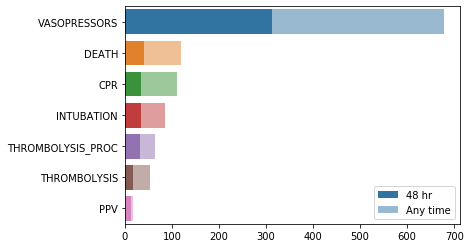

In [312]:
ax = sns.barplot(y=srs48hrOutcomeCounts.index,
                 x=srs48hrOutcomeCounts.values,
                 orient='h', label='48 hr')
sns.barplot(y=srsOutcomeCounts.index,
            x=srsOutcomeCounts.values,
            orient='h', alpha=0.5, ax=ax, label='Any time')
ax.legend()
ax.set_ylabel()

In [252]:
dfExpandedOutcome.to_csv(os.path.join(strDataDir, 'df_expanded_outcome.csv'))

(-50, 4606.7116071290575)

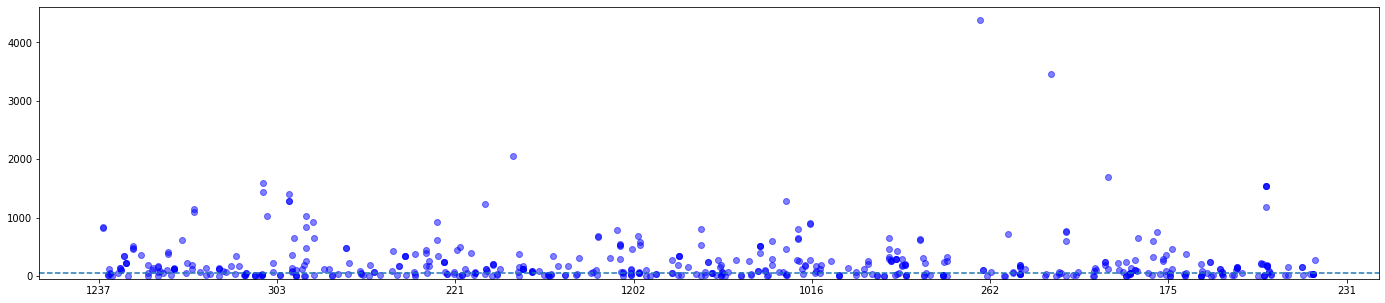

In [110]:
fig, ax = plt.subplots(figsize=(24, 5))
for strOrderTimeCol in lsOrderTimeCols:
    ax.scatter(dfExpandedOutcome.index, dfExpandedOutcome.loc[:, strOrderTimeCol]/3600, c='b', alpha=0.5)
ax.axhline(y=48, linestyle='--')
ax.set_xticklabels(dfExpandedOutcome.index)
ax.set_ylim(-50)

In [270]:
lsProportion = []
srsSeverePresent = dfEchoAndOutcome['bSevereInNarrative'].value_counts()
srs48hrSeverePresent = dfEchoAndOutcome[dfEchoAndOutcome['bSevereInNarrative']]['b48hr'].value_counts()
lsProportion.append(srs48hrSeverePresent[True]/srsSeverePresent[True])
lsProportion.append(srs48hrSeverePresent[False]/srsSeverePresent[True])

Text(0, 0.5, 'Proportion with 48 hour outcome')

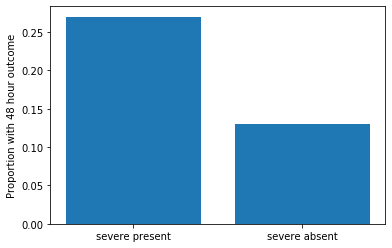

In [273]:
f, ax = plt.subplots()
ax.bar(['severe present', 'severe absent'],
       [34/126, 79/610])
ax.set_ylabel('Proportion with 48 hour outcome')